In [85]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import plotly.graph_objects as go
from scipy.optimize import minimize, Bounds, LinearConstraint
from matplotlib.cm import ScalarMappable
import scipy.stats
plt.style.use('grayscale')

In [3]:
risk_free = 0.04/12/100

df = pd.read_csv('/Users/frederikfindsen/Documents/GitHub/Project-Finance/data.csv', index_col = 'date').drop('Unnamed: 0',axis=1)

In [4]:
airlines = ['DLAKY',
             'LUV',
             'EZJ',
             'RYAAY',
             'UAL',
             'AAL',
             'SAVE']
beer = ['CABGY',
             'HEINY',
             'BUD',
             'HARB-B.CO',
             'DEO',
             'TAP',
             'TSGTF',
             'ASBRF']

In [99]:
#Functions
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    
    returns = np.sum(mean_returns*weights)*12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    
    return std, returns

  
def random_portfolios(returns, num_portfolios=10000, risk_free_rate=risk_free):
    
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    N = len(returns.columns)
    
    results = np.zeros((3,num_portfolios))
    weights_record = []
    
    results = pd.DataFrame({'return':[],'std':[],'sharperatio':[]})
    
    for i in range(num_portfolios):
        
        weights = np.random.random(N)
        weights /= np.sum(weights)
        weights_record.append(weights)
        std_dev, port_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        
        results.loc[len(results.index)] = [port_return, std_dev,(port_return - risk_free_rate) / std_dev]
    
    return results, weights_record


def volatiltiy(W, exp_ret, cov):
    
    vol = np.sqrt(np.dot(W.T, np.dot(cov, W))) * np.sqrt(12)
    
    return vol


# Function that runs optimizer

def optimize(func, target_return,exp_ret, cov,opt_bounds):
    W = np.ones((exp_ret.shape[0],1))*(1.0/exp_ret.shape[0])
    
    opt_constraints = ({'type': 'eq',
                        'fun': lambda W: 1.0 - np.sum(W)},
                       {'type': 'eq',
                        'fun': lambda W: target_return - W.T@exp_ret})
    
    optimal_weights = minimize(func, W, 
                               args=(exp_ret, cov),
                               method='SLSQP',
                               bounds=opt_bounds,
                               constraints=opt_constraints)
    
    return optimal_weights['x']

def optimize_min(func,exp_ret, cov):
    opt_bounds = Bounds(0, 1)
    W = np.ones((exp_ret.shape[0],1))*(1.0/exp_ret.shape[0])
    
    opt_constraints = ({'type': 'eq',
                        'fun': lambda W: 1.0 - np.sum(W)})
    
    optimal_weights = minimize(func, W, 
                               args=(exp_ret, cov),
                               method='SLSQP',
                               bounds=opt_bounds,
                               constraints=opt_constraints)
    
    std, ret = portfolio_annualised_performance(optimal_weights['x'],exp_ret,cov)
    
    return [std, ret]

def efficient_frontier(df,opt_bounds = Bounds(0,1), risk_free=0):
    
    target_return_range = np.linspace(0,0.2,200) #Range for iterating through different optimal returns

    efficient_df = pd.DataFrame({'return':[],'std':[],'sharperatio':[],'weights':[]})
    efficient_port = list()

    min_port = optimize_min(volatiltiy, exp_ret = df.mean(), cov = df.cov())
    
    for target_return in target_return_range: #Creating efficient frontier
        x = optimize(volatiltiy,
                     target_return, 
                     exp_ret = df.mean(), 
                     cov = df.cov(),
                     opt_bounds = opt_bounds)
        efficient_port.append(x)
        
        std, returns = portfolio_annualised_performance(x,df.mean(),df.cov())
        
        efficient_df.loc[len(efficient_df.index)] = [returns, std, (returns - risk_free) / std, x]

    return efficient_df, min_port

def plot_efficientfrontier(efficient_df_list,info_df=None, titles=None, min_port=None):
    
    fig, axes = plt.subplots(2,len(efficient_df_list),figsize=(15,8))
    
    for df, i in zip(efficient_df_list,range(len(efficient_df_list))): 
        
        axes[0][i].plot(df['std'],df['return'])
        axes[0][i].set_xlabel('Standard Deviation, Annualized')
        axes[0][i].set_ylabel('Expected Return, Annualized')
        
        axes[1][i].bar(np.arange(len(info_df[i]['stock'])),df[df['std']==df['std'].min()]['weights'].values[0],width=0.2) 
        
        axes[1][i].set_xticks(np.arange(len(info_df[i]['stock']))) 
        axes[1][i].set_xticklabels(info_df[i]['stock'],rotation = 55)
        axes[1][i].set_title('Min Port Weights')
        
        
        
    if info_df != None:
        for stocks_df, i in zip(info_df,range(len(efficient_df_list))):
            for index, row in stocks_df.iterrows():
                axes[0][i].scatter(row['std'],row['return'])
                axes[0][i].annotate(row['stock'], (row['std'], row['return']), xytext=(5,5), textcoords='offset points')
    
    if titles != None:
        for title, i in zip(titles,range(len(titles))): 
            axes[0][i].set_title(title)
    
    if min_port != None:
        for port, i in zip(min_port,range(len(min_port))): 
            axes[0][i].scatter(port[0],port[1])
            axes[0][i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points') 
    
            
    
    fig.tight_layout()
    
    return fig

def tangent_plot():
    
    fig, axes = plt.subplots(1,len(efficient_df_list),figsize=(15,5))
    
    for df, i in zip(efficient_df_list,range(len(efficient_df_list))): 
        
        axes[i].plot(df['std'],df['return'])
        axes[i].set_xlabel('Standard Deviation, Annualized')
        axes[i].set_ylabel('Expected Return, Annualized')
    
    if info_df != None:
        for stocks_df, i in zip(info_df,range(len(efficient_df_list))):
            for index, row in stocks_df.iterrows():
                axes[i].scatter(row['std'],row['return'])
                axes[i].annotate(row['stock'], (row['std'], row['return']), xytext=(5,5), textcoords='offset points')
    
    if titles != None:
        for title, i in zip(titles,range(len(titles))): 
            axes[i].set_title(title)
    
    if min_port != None:
        for port, i in zip(min_port,range(len(min_port))): 
            axes[i].scatter(port[0],port[1])
            axes[i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points') 
            
            
    fig.tight_layout()
    
def calc_risk(df, returns_df, value, alpha, b = 500, n=120):
    
    weighted_returns = (df[df['std']== df['std'].min()]['weights'].values[0] * returns_df)
    returns = weighted_returns.sum(axis=1)
        
    boot_data = list()
    var = -value*(returns.mean()+scipy.stats.norm.ppf(alpha)*returns.std()) 
    
    for i in range(b):
        boot_sample = returns.sample(n)
        boot_data.append(-value*(boot_sample.mean()+scipy.stats.norm.ppf(alpha)*boot_sample.std()))
    
    range_1 = 2*returns.mean()-np.quantile(boot_data,1-alpha/2)
    range_2 = 2*returns.mean()-np.quantile(boot_data,alpha/2)
    
    return [range_1,range_2]

### Efficient Frontier and Min variance portfolio without Risk Free Asset

In [79]:
airlines_df = df[airlines]
beer_df = df[beer]

airlines_info = pd.DataFrame({'stock':airlines,'return':airlines_df.mean().values*12,'std':airlines_df.std().values*np.sqrt(12)})
beer_info = pd.DataFrame({'stock':beer,'return':beer_df.mean().values*12,'std':beer_df.std().values*np.sqrt(12)})
all_info = pd.DataFrame({'stock':df.columns,'return':df.mean().values*12,'std':df.std().values*np.sqrt(12)})

info_df_list = [airlines_info, beer_info, all_info]
df_list = [airlines_df, beer_df, df]

In [7]:
efficient_df_airline, min_port_airline = efficient_frontier(airlines_df,opt_bounds=Bounds(0,1))
efficient_df_beer, min_port_beer = efficient_frontier(beer_df,opt_bounds=Bounds(0,1))
efficient_df, min_port = efficient_frontier(df,opt_bounds=Bounds(0,1))

efficient_df_list = [efficient_df_airline, efficient_df_beer, efficient_df]

/Users/frederikfindsen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


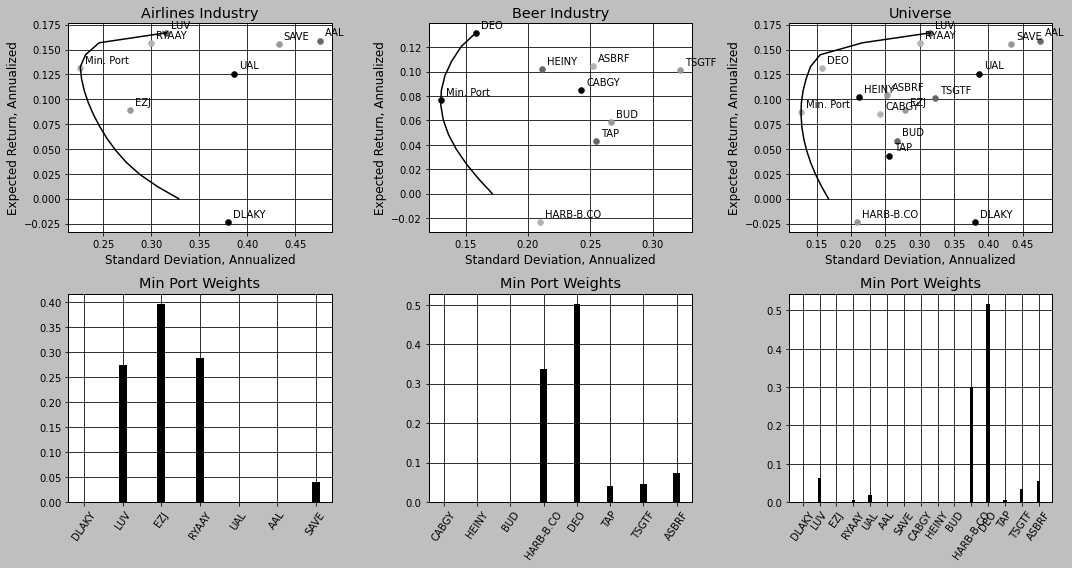

In [8]:

min_port_list = [min_port_airline, min_port_beer, min_port]

efficient_plot = plot_efficientfrontier(efficient_df_list,
                              info_df_list,
                              titles =['Airlines Industry','Beer Industry','Universe'],
                            min_port = min_port_list)

In [100]:
var_list = list()
for port, returns in zip(efficient_df_list,df_list):
    var_list.append(calc_risk(port, returns ,100000,alpha=0.05))

In [101]:
pd.DataFrame(var_list)

,0,1
0,-10089.419689,-8822.421773
1,-5655.872543,-5022.116087
2,-5441.011750,-4813.675411


In [177]:
efficient_plot.savefig('/Users/frederikfindsen/Documents/GitHub/Project-Finance/assets/efficient_plot.png')

#### Efficient Portfolio with Risk Free 

In [5]:
df['rf'] = 0.04/12/100
airlines.append('rf')
beer.append('rf')

airlines_df = df[airlines]
beer_df = df[beer]

airlines_info = pd.DataFrame({'stock':airlines,'return':airlines_df.mean().values*12,'std':airlines_df.std().values*np.sqrt(12)})
beer_info = pd.DataFrame({'stock':beer,'return':beer_df.mean().values*12,'std':beer_df.std().values*np.sqrt(12)})
all_info = pd.DataFrame({'stock':df.columns,'return':df.mean().values*12,'std':df.std().values*np.sqrt(12)})

info_df_list = [airlines_info, beer_info, all_info]

In [228]:
efficient_df_airline, min_port_airline = efficient_frontier(airlines_df,opt_bounds=Bounds(0,1))
efficient_df_beer, min_port_beer = efficient_frontier(beer_df,opt_bounds=Bounds(0,1))
efficient_df, min_port = efficient_frontier(df,opt_bounds=Bounds(0,1))
efficient_df_list_rf = [efficient_df_airline, efficient_df_beer, efficient_df]

/Users/frederikfindsen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<ipython-input-230-3d24a4d61d0f>:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


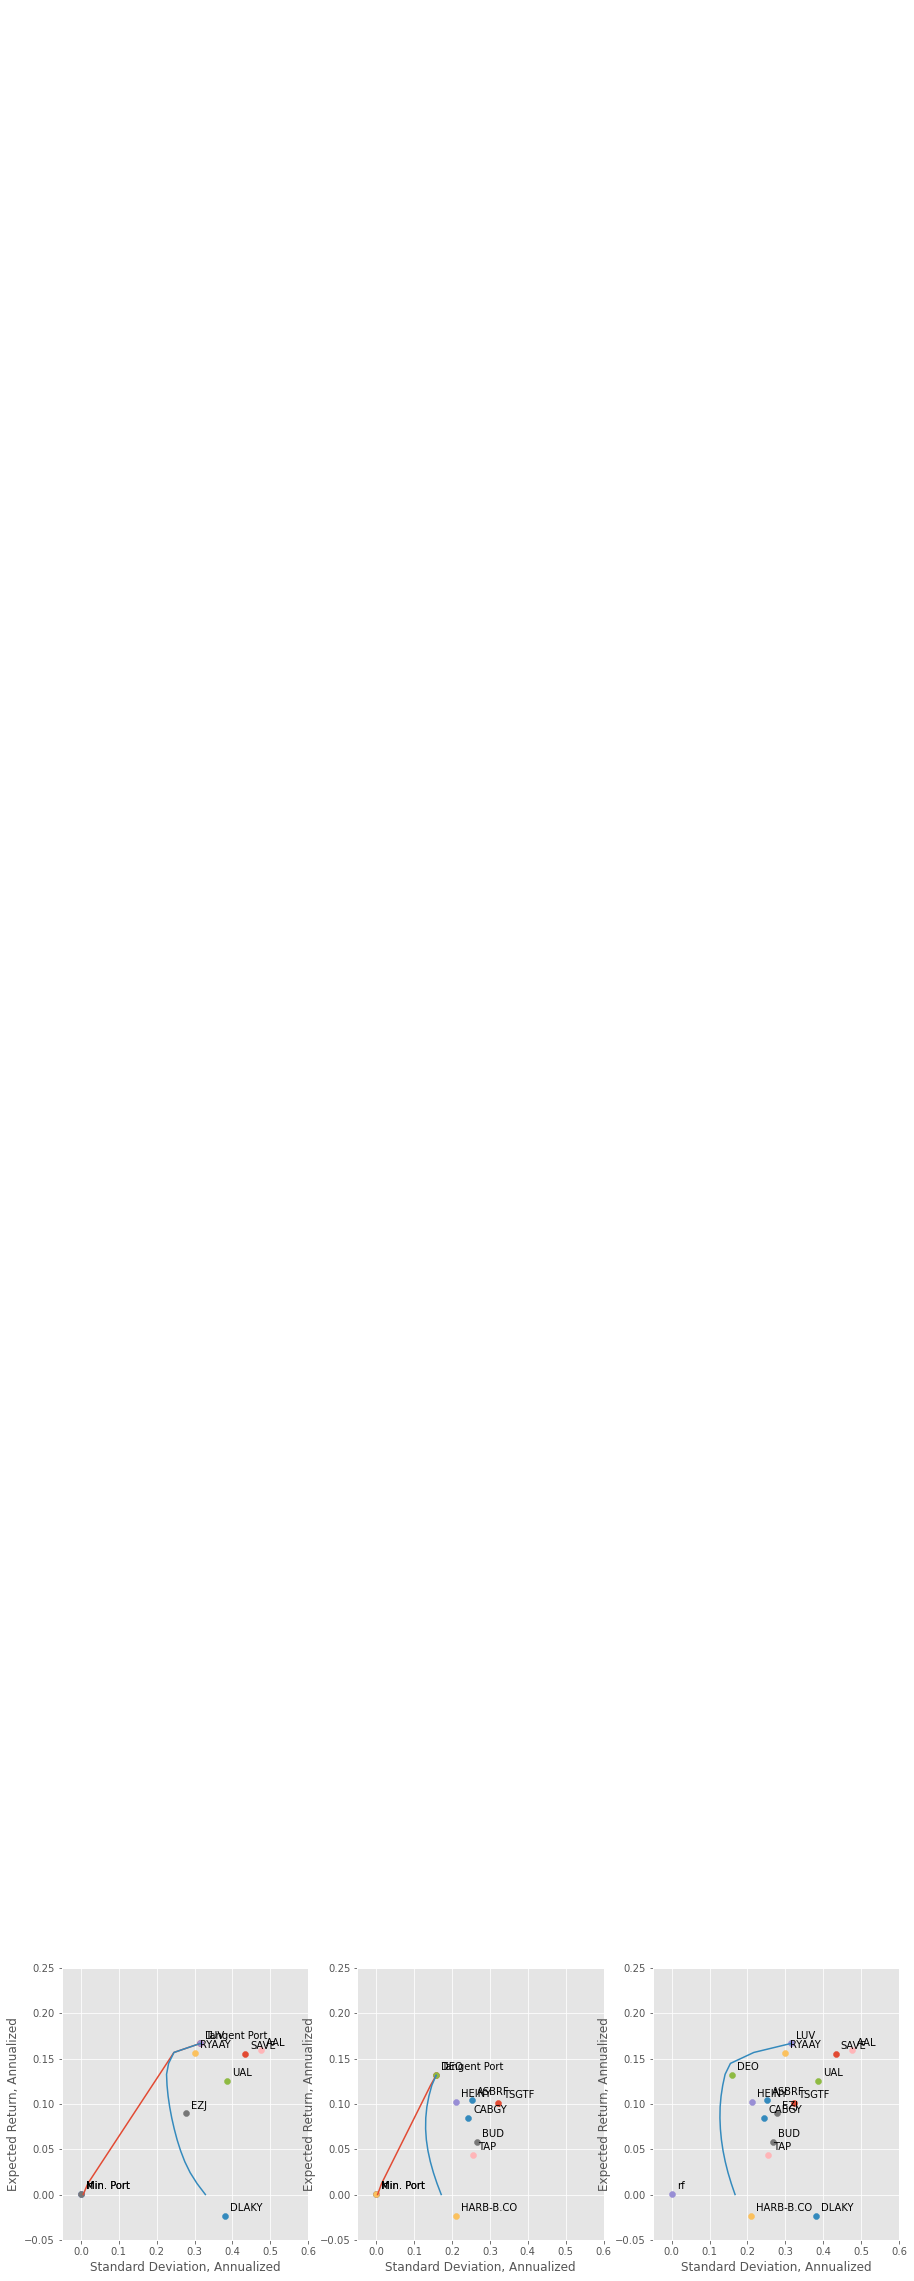

In [230]:
min_port_list = [min_port_airline, min_port_beer, min_port]

fig, axes = plt.subplots(1,len(efficient_df_list),figsize=(15,5))

for df, i in zip(efficient_df_list_rf,range(len(efficient_df_list_rf))): 
    axes[i].plot(df['std'],df['return'])
    axes[i].set_xlabel('Standard Deviation, Annualized')
    axes[i].set_ylabel('Expected Return, Annualized')
    
    axes[i].set_ylim(-0.05,0.25)
    axes[i].set_xlim(-0.05,0.6)
    
    axes[i].scatter(df[df['std']==df['std'].max()]['std'],df[df['std']==df['std'].max()]['return'])
    axes[i].annotate('Tangent Port' ,
                     (df[df['std']==df['std'].max()]['std'],df[df['std']==df['std'].max()]['return']),
                     xytext=(5,5), 
                     textcoords='offset points') 
    
    
for df, i in zip(efficient_df_list,range(len(efficient_df_list))): 
    axes[i].plot(df['std'],df['return'])
    axes[i].set_xlabel('Standard Deviation, Annualized')
    axes[i].set_ylabel('Expected Return, Annualized')

    
for stocks_df, i in zip(info_df_list,range(len(efficient_df_list))):
    for index, row in stocks_df.iterrows():
        axes[i].scatter(row['std'],row['return'])
        axes[i].annotate(row['stock'], (row['std'], row['return']), xytext=(5,5), textcoords='offset points')

for port, i in zip(min_port_list,range(len(min_port))): 
    axes[i].scatter(port[0],port[1])
    axes[i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points') 

    
for port, i in zip(min_port_list,range(len(min_port))): 
    axes[i].scatter(port[0],port[1])
    axes[i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points') 



    
fig.tight_layout()